In [52]:
import torch
import torch.nn as nn
import numpy as np

class AttentionModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32):
        super(AttentionModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.attenton_dim = 64

        self.attn_alpha = []
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)

        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, self.attenton_dim),
            nn.Tanh(),
            nn.Linear(self.attenton_dim, 1)
        )

        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 1),
     
            nn.Sigmoid()

        )

    def forward(self, x):

        lstm_out, _ = self.lstm(x)
        

        e = self.attention(lstm_out)#.squeeze(-1)

        alpha = torch.softmax(e, dim=1).unsqueeze(-1)

        context = torch.sum(alpha * lstm_out, dim=1)
        output = self.predictor(context)  

        self.attn_alpha.append(alpha.squeeze(-1).detach().numpy())

        return output, alpha.squeeze(-1)

    def train_model(self, data, device='cpu', num_epochs=50, patience=5, learning_rate=0.01):
        self.to(device)
        self.train()
        
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        best_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            total_loss = 0.0
            train_losses = []

            for inputs, targets in data:
                
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs, _ = self(inputs)
                loss = criterion(outputs.squeeze(), targets.float())
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                train_losses.append(loss.item())

            avg_loss = total_loss / len(data)


            if avg_loss < best_loss:
                best_loss = avg_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break

        torch.save(self.state_dict(), 'best_model.pth')
        print("Training complete.")

    @classmethod
    def load_model(cls, checkpoint_path, device='cpu', **kwargs):
        """
        Loads a trained AttentionModel.
        Args:
            checkpoint_path (str): Path to saved .pth file.
            device (str): 'cpu' or 'cuda'.
            kwargs: Keyword arguments for the model constructor (e.g., input_dim, hidden_dim)
        Returns:
            AttentionModel instance with weights loaded.
        """
        model = cls(**kwargs)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.to(device)
        model.eval()
        return model

In [53]:
X = torch.tensor([np.sin(np.multiply(np.add(i,torch.rand(1, 1)), torch.ones(1,1))).tolist() for i in range(1000)])
# Y = torch.tensor([0 if sum(x)> 0 else 1  for x in X])
# print(len(X), len(Y))

def build_training_data(X, batches = 100, length=30, batch_size=32):
    training_data = []
    if len(X) < length:
        raise ValueError("Input data length must be at least equal to the specified length.")
    
    for i in range(batches):
        batchX = []
        batchY=[]
        for _ in range(batch_size):
            start = np.random.randint(0, len(X) - length)
            end = start + length
            batchX.append(X[start:end])
            batchY.append(X[end])
        training_data.append((torch.stack(batchX).squeeze(-1).squeeze(-1), torch.tensor(batchY)))

    return training_data



data = build_training_data(X,batches=100, length=30, batch_size=32)
 
print(data[0][0].shape)


torch.Size([32, 30])


In [58]:
model = AttentionModel(input_dim=30, hidden_dim=32)

model.train_model(data=data, device='cpu', num_epochs=50, patience=5, learning_rate=0.0001)
#
print(model.attn_alpha)

yhat = model(data[0][0].unsqueeze(0).float())

from matplotlib import pyplot as plt
from torchviz import make_dot
make_dot(yhat, params=dict(list(model.named_parameters()))).render("model_architecture", format="png")


Epoch 1/50, Loss: 0.7470
Epoch 2/50, Loss: 0.5368
Epoch 3/50, Loss: 0.5230
Epoch 4/50, Loss: 0.5204
Epoch 5/50, Loss: 0.5193
Epoch 6/50, Loss: 0.5188
Epoch 7/50, Loss: 0.5184
Epoch 8/50, Loss: 0.5182
Epoch 9/50, Loss: 0.5180
Epoch 10/50, Loss: 0.5179
Epoch 11/50, Loss: 0.5178
Epoch 12/50, Loss: 0.5177
Epoch 13/50, Loss: 0.5176
Epoch 14/50, Loss: 0.5175
Epoch 15/50, Loss: 0.5174
Epoch 16/50, Loss: 0.5173
Epoch 17/50, Loss: 0.5172
Epoch 18/50, Loss: 0.5170
Epoch 19/50, Loss: 0.5167
Epoch 20/50, Loss: 0.5160
Epoch 21/50, Loss: 0.5144
Epoch 22/50, Loss: 0.5131
Epoch 23/50, Loss: 0.5126
Epoch 24/50, Loss: 0.5120
Epoch 25/50, Loss: 0.5117
Epoch 26/50, Loss: 0.5115
Epoch 27/50, Loss: 0.5114
Epoch 28/50, Loss: 0.5114
Epoch 29/50, Loss: 0.5113
Epoch 30/50, Loss: 0.5113
Epoch 31/50, Loss: 0.5113
Epoch 32/50, Loss: 0.5113
Epoch 33/50, Loss: 0.5112
Epoch 34/50, Loss: 0.5112
Epoch 35/50, Loss: 0.5112
Epoch 36/50, Loss: 0.5111
Epoch 37/50, Loss: 0.5111
Epoch 38/50, Loss: 0.5111
Epoch 39/50, Loss: 0.

'model_architecture.png'

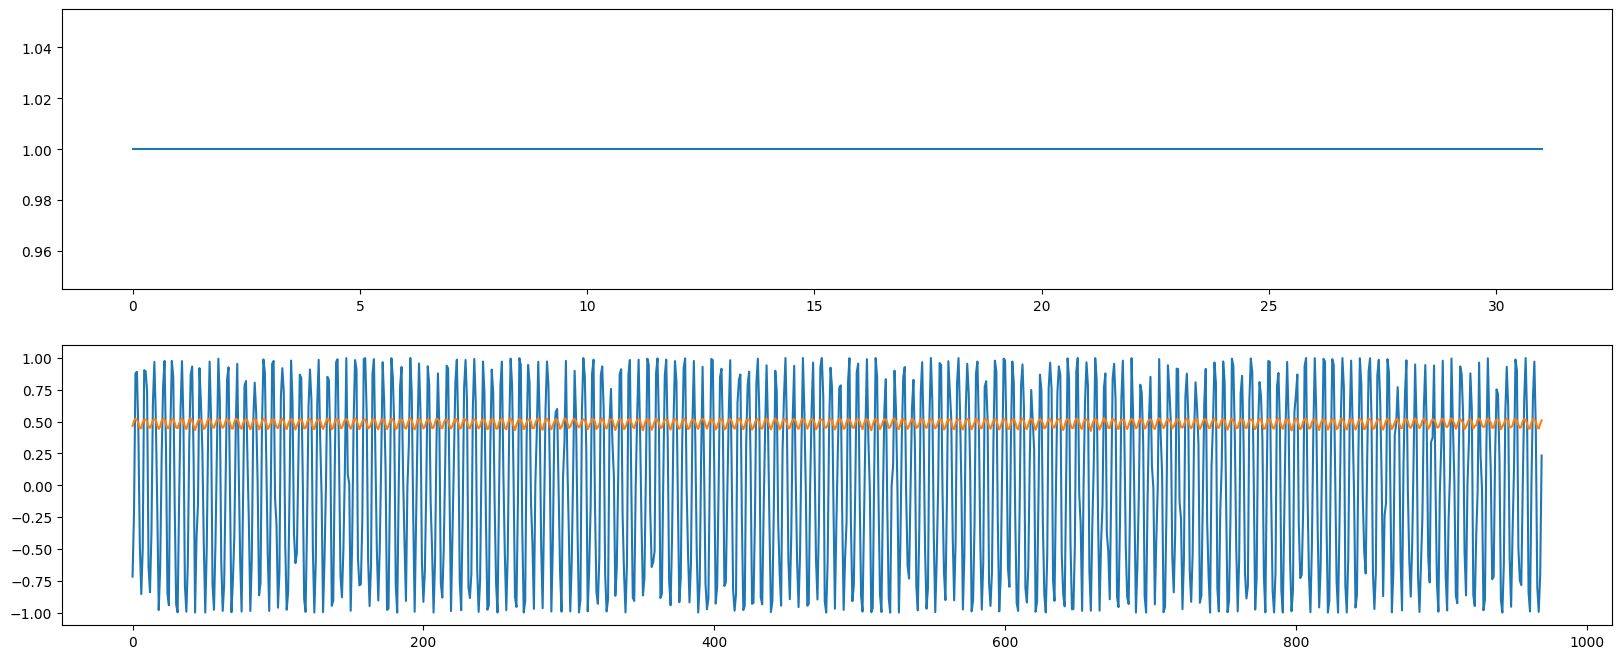

In [55]:

x_hat = []
for idx, _ in enumerate(X[:-30]):
    x = X[idx:idx+30]

    yhat = model(x.squeeze(-1).transpose(0,1))
    x_hat.append(yhat[0].detach().numpy())

x_hat = torch.tensor(x_hat).squeeze(-1)
ax, fig = plt.subplots(2, 1, figsize=(20, 8))
fig[0].plot(model.attn_alpha[0])

fig[1].plot(X[30:].squeeze(-1).detach().numpy(), label='Actual')
fig[1].plot(x_hat.detach().numpy(), label='Actual')

plt.show()



